In [2]:
from google.cloud import bigquery

In [3]:
%load_ext google.cloud.bigquery

In [4]:
bq = bigquery.Client()

In [4]:
%%bigquery
SELECT *
FROM bigquery-public-data.github_repos.languages
WHERE repo_name LIKE "open-lambda/%"

Query is running:   0%|          |

Downloading:   0%|          |

,repo_name,language
0,open-lambda/open-lambda,"[{'name': 'C', 'bytes': 31159}, {'name': 'Dock..."
1,open-lambda/load-balancer,"[{'name': 'C', 'bytes': 210}, {'name': 'Go', '..."


In [6]:
bq.get_table("bigquery-public-data.github_repos.languages").schema

[SchemaField('repo_name', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('language', 'RECORD', 'REPEATED', None, None, (SchemaField('name', 'STRING', 'NULLABLE', None, None, (), None), SchemaField('bytes', 'INTEGER', 'NULLABLE', None, None, (), None)), None)]

In [8]:
%%bigquery
SELECT repo_name, language[OFFSET(0)] as first, language[OFFSET(ARRAY_LENGTH(language)-1)] as last
FROM bigquery-public-data.github_repos.languages
WHERE repo_name LIKE "open-lambda/%"

Query is running:   0%|          |

Downloading:   0%|          |

,repo_name,first,last
0,open-lambda/open-lambda,"{'name': 'C', 'bytes': 31159}","{'name': 'Shell', 'bytes': 1182}"
1,open-lambda/load-balancer,"{'name': 'C', 'bytes': 210}","{'name': 'Makefile', 'bytes': 1105}"


In [9]:
%%bigquery
SELECT repo_name, language[OFFSET(0)].name as first, language[OFFSET(ARRAY_LENGTH(language)-1)].name as last
FROM bigquery-public-data.github_repos.languages
WHERE repo_name LIKE "open-lambda/%"

Query is running:   0%|          |

Downloading:   0%|          |

,repo_name,first,last
0,open-lambda/open-lambda,C,Shell
1,open-lambda/load-balancer,C,Makefile


In [ ]:
# for this GitHub, how often is C used Dockerfiles?

In [14]:
%%bigquery
SELECT repo_name, L1.name AS name1, L2.name as name2
FROM bigquery-public-data.github_repos.languages
CROSS JOIN UNNEST(language) AS L1
CROSS JOIN UNNEST(language) AS L2
WHERE repo_name LIKE "open-lambda/%"
AND   L1.name = 'C' AND L2.name = 'Dockerfile'

Query is running:   0%|          |

Downloading:   0%|          |

,repo_name,name1,name2
0,open-lambda/open-lambda,C,Dockerfile


In [15]:
# what are the most common languages?

In [18]:
%%bigquery df
SELECT L.name AS name, COUNT(*) as count
FROM bigquery-public-data.github_repos.languages
CROSS JOIN UNNEST(language) AS L
GROUP BY L.name
ORDER BY count DESC
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

<Axes: xlabel='name'>

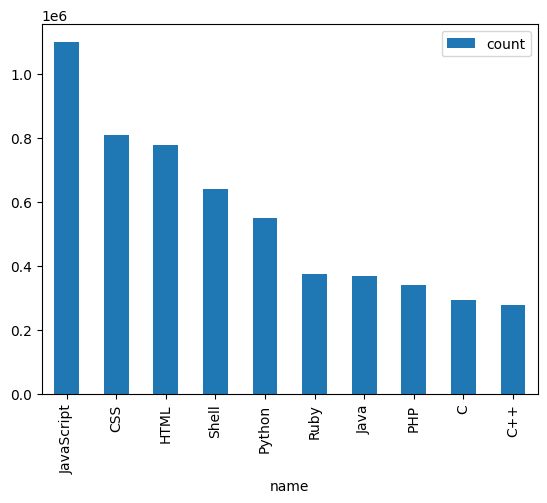

In [21]:
df.set_index("name").plot.bar()

In [ ]:
# what software licenses are used most with Python projects?

In [25]:
%%bigquery df
SELECT licenses.license, COUNT(*) as count
FROM bigquery-public-data.github_repos.languages
CROSS JOIN UNNEST(language) AS L
INNER JOIN bigquery-public-data.github_repos.licenses ON languages.repo_name = licenses.repo_name
WHERE L.name = 'Python'
GROUP BY license
ORDER BY count DESC

Query is running:   0%|          |

Downloading:   0%|          |

<Axes: xlabel='license'>

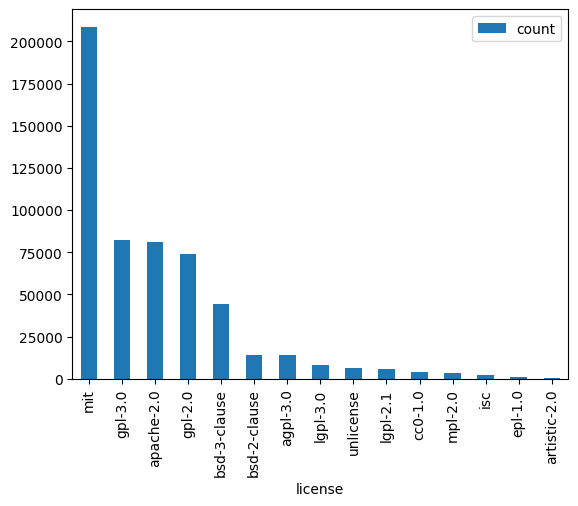

In [28]:
df.set_index("license").plot.bar()

In [29]:
# example 1: BigQuery Table
config = bigquery.LoadJobConfig(source_format="PARQUET", write_disposition="WRITE_TRUNCATE")
url = "gs://cs544nov29/hdma-wi-2021.parquet"
job = bq.load_table_from_uri(url, "cs544-f23.test1.loans", job_config=config)
job.result()

LoadJob<project=cs544-f23, location=US, id=46ccadc9-e407-4398-afc4-60e98f8d3791>

In [30]:
# example 2: External Table (GCS)
config = bigquery.ExternalConfig(source_format="PARQUET")
config.source_uris = ["gs://cs544nov29/hdma-wi-2021.parquet"]
# config.autodetect = True
table = bigquery.Table("cs544-f23.test1.loans-external")
table.external_data_configuration = config
bq.create_table(table, exists_ok=True)

Table(TableReference(DatasetReference('cs544-f23', 'test1'), 'loans-external'))

In [31]:
# example 3: external table (sheets)
# form: https://forms.gle/DKYMSJNkfPR8S1f46
# sheet: https://docs.google.com/spreadsheets/d/11UeIBqQylAyNUBsIO54p6WiYJWHayQMfHDbUWq1jGco/edit#gid=288285146
config = bigquery.ExternalConfig(source_format="GOOGLE_SHEETS")
config.source_uris = ["https://docs.google.com/spreadsheets/d/11UeIBqQylAyNUBsIO54p6WiYJWHayQMfHDbUWq1jGco"]
config.autodetect = True
table = bigquery.Table("cs544-f23.test1.applications")
table.external_data_configuration = config
bq.create_table(table, exists_ok=True)

Table(TableReference(DatasetReference('cs544-f23', 'test1'), 'applications'))

In [37]:
%%bigquery
SELECT COUNT(*)
FROM test1.applications

Query is running:   0%|          |

Downloading:   0%|          |

,f0_
0,22


In [38]:
# geopandas, extends pandas (GeoDataFrame is a sub class of pandas's DataFrame, and it has a column of shapes)
# pip3 install geopandas

In [40]:
# FIPS code for WI is 55
df = bq.query("""
SELECT county_geom
FROM bigquery-public-data.geo_us_boundaries.counties
WHERE state_fips_code = '55'
""").to_geodataframe()
df.head(3)

,county_geom
0,"POLYGON ((-90.92542 46.58730, -90.92471 46.588..."
1,"POLYGON ((-87.43242 45.11177, -87.43923 45.087..."
2,"POLYGON ((-91.16601 44.33510, -91.16600 44.333..."


In [41]:
type(df)

geopandas.geodataframe.GeoDataFrame

<Axes: >

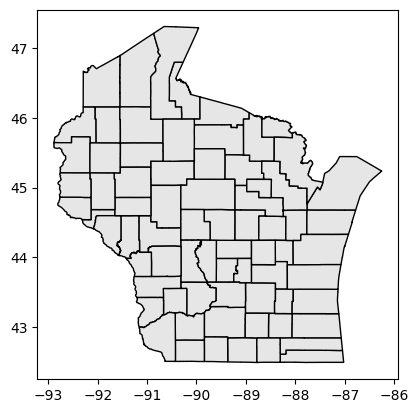

In [43]:
df.plot(color="0.9", edgecolor="k")

In [47]:
# get our copy of just WI
df = bq.query("""
CREATE OR REPLACE TABLE `cs544-f23.test1.wi`
AS
SELECT county_name, county_geom
FROM bigquery-public-data.geo_us_boundaries.counties
WHERE state_fips_code = '55'
""").to_geodataframe()

In [48]:
df = bq.query("SELECT * FROM test1.wi").to_geodataframe()

In [50]:
with open("wi.geojson", "w") as f:
    f.write(df.to_json())

<Axes: >

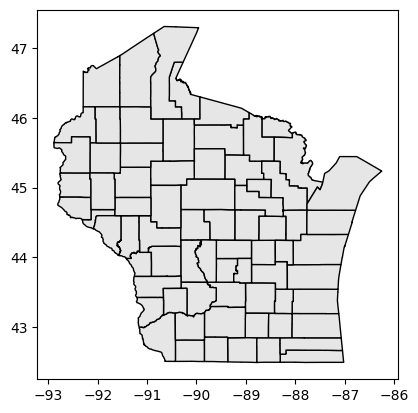

In [51]:
bq.query("SELECT county_geom FROM test1.wi").to_geodataframe().plot(color="0.9", edgecolor="k")

<Axes: >

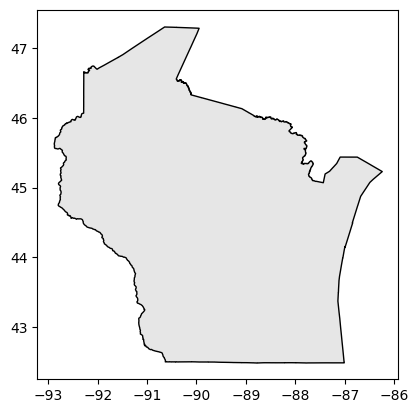

In [52]:
# ST_????? (spatial type)
bq.query("SELECT ST_UNION_AGG(county_geom) FROM test1.wi").to_geodataframe().plot(color="0.9", edgecolor="k")

<Axes: >

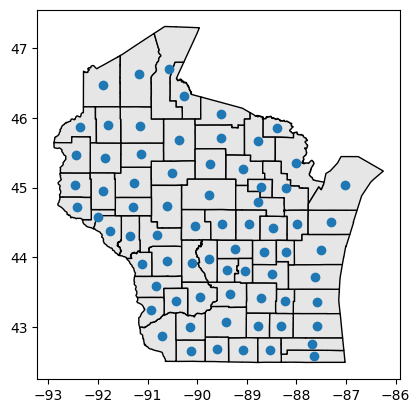

In [55]:
# centroids
ax = bq.query("SELECT county_geom FROM test1.wi").to_geodataframe().plot(color="0.9", edgecolor="k")
bq.query("SELECT ST_CENTROID(county_geom) FROM test1.wi").to_geodataframe().plot(ax=ax)

<Axes: >

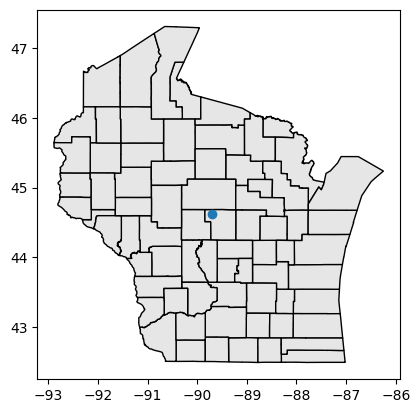

In [56]:
# one centroid
ax = bq.query("SELECT county_geom FROM test1.wi").to_geodataframe().plot(color="0.9", edgecolor="k")
bq.query("SELECT ST_CENTROID_AGG(county_geom) FROM test1.wi").to_geodataframe().plot(ax=ax)

In [64]:
bq.query("""
CREATE OR REPLACE TABLE test1.houses
AS
SELECT *, ST_GEOGPOINT(longitude, latitude) as loc
FROM test1.applications
""").to_geodataframe()

""


In [ ]:
# how far is each house from the WI capitol?

In [71]:
closest10 = bq.query("""
SELECT loc, ST_DISTANCE(loc, ST_GEOGPOINT(-89.384107, 43.074715)) / 1000 AS km
FROM test1.houses
ORDER BY km ASC
LIMIT 10
""").to_geodataframe()

<Axes: >

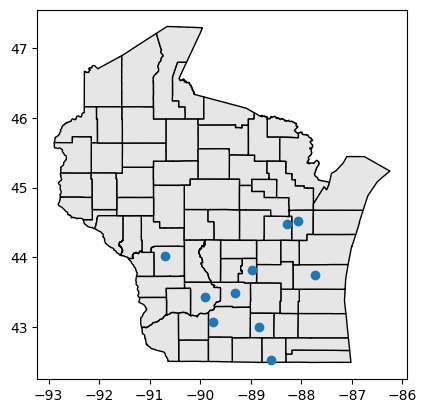

In [73]:
ax = bq.query("SELECT county_geom FROM test1.wi").to_geodataframe().plot(color="0.9", edgecolor="k")
closest10.plot(ax=ax)

In [74]:
# ST_Within(point, shape)
# which houses are in which counties?

In [5]:
wi_houses = bq.query("""
SELECT houses.*, wi.county_name
FROM cs544-f23.test1.houses CROSS JOIN cs544-f23.test1.wi
WHERE ST_Within(loc, county_geom)
""").to_geodataframe()
wi_houses

,Timestamp,loan_amount,income,latitude,longitude,loc,county_name
0,2023-11-27 21:10:35.948000+00:00,200000,20000,45.058784,-87.665404,POINT (-87.66540 45.05878),Marinette
1,2023-11-27 21:15:03.160000+00:00,300000,25000,45.233277,-88.027144,POINT (-88.02714 45.23328),Marinette
2,2023-11-27 21:05:40.625000+00:00,100000,10000,43.069646,-89.753298,POINT (-89.75330 43.06965),Dane
3,2023-11-27 21:22:54.152000+00:00,340000,43000,45.698024,-89.520437,POINT (-89.52044 45.69802),Oneida
4,2023-11-27 21:23:37.783000+00:00,500000,34000,43.493548,-89.320734,POINT (-89.32073 43.49355),Columbia
5,2023-11-27 21:15:51.755000+00:00,150000,20000,43.006125,-88.846895,POINT (-88.84690 43.00612),Jefferson
6,2023-11-27 21:16:32.351000+00:00,210000,25000,46.815340,-90.829876,POINT (-90.82988 46.81534),Bayfield
7,2023-11-27 21:25:11.540000+00:00,120000,45000,43.436125,-89.899740,POINT (-89.89974 43.43612),Sauk
8,2023-11-27 21:13:07.711000+00:00,300000,30000,44.523038,-88.072896,POINT (-88.07290 44.52304),Brown
9,2023-11-27 21:18:10.904000+00:00,230000,18000,43.746807,-87.723928,POINT (-87.72393 43.74681),Sheboygan


<Axes: >

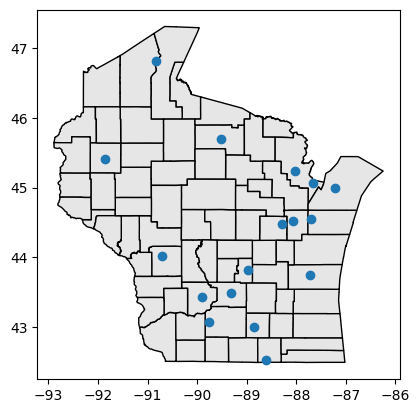

In [8]:
ax = bq.query("SELECT county_geom FROM test1.wi").to_geodataframe().plot(color="0.9", edgecolor="k")
wi_houses.plot(ax=ax)

In [ ]:
# ST_SNAPTOGRID, ST_GEOHASH

<Axes: >

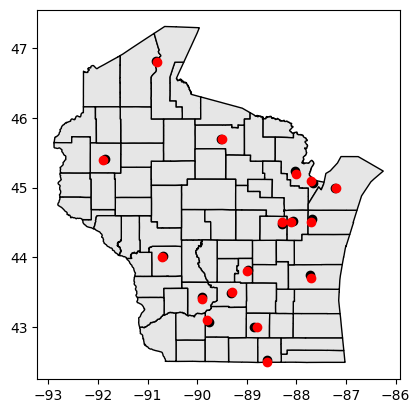

In [11]:
wi_houses = bq.query("""
SELECT houses.*, wi.county_name
FROM cs544-f23.test1.houses CROSS JOIN cs544-f23.test1.wi
WHERE ST_Within(loc, county_geom)
""").to_geodataframe()

approx_wi_houses = bq.query("""
SELECT ST_SNAPTOGRID(houses.loc, 0.1), wi.county_name
FROM cs544-f23.test1.houses CROSS JOIN cs544-f23.test1.wi
WHERE ST_Within(loc, county_geom)
""").to_geodataframe()

ax = bq.query("SELECT county_geom FROM test1.wi").to_geodataframe().plot(color="0.9", edgecolor="k")
wi_houses.plot(ax=ax, color="k")
approx_wi_houses.plot(ax=ax, color="r")

In [16]:
%%bigquery
SELECT houses.loc, ST_GEOHASH(loc, 2) AS hash_code, wi.county_name
FROM cs544-f23.test1.houses CROSS JOIN cs544-f23.test1.wi
WHERE ST_Within(loc, county_geom)

Query is running:   0%|          |

Downloading:   0%|          |

,loc,hash_code,county_name
0,POINT(-90.6986549 44.0127304),9z,Monroe
1,POINT(-88.0728955 44.5230382),dp,Brown
2,POINT(-89.3207337 43.4935476),dp,Columbia
3,POINT(-88.846895 43.0061248),dp,Jefferson
4,POINT(-89.5204365 45.6980241),f0,Oneida
5,POINT(-91.8657515 45.4032143),cb,Barron
6,POINT(-89.7532978 43.0696456),dp,Dane
7,POINT(-87.7239278 43.7468067),dp,Sheboygan
8,POINT(-88.9729627 43.8124645),dp,Green Lake
9,POINT(-87.229077 45.000711),f0,Door
